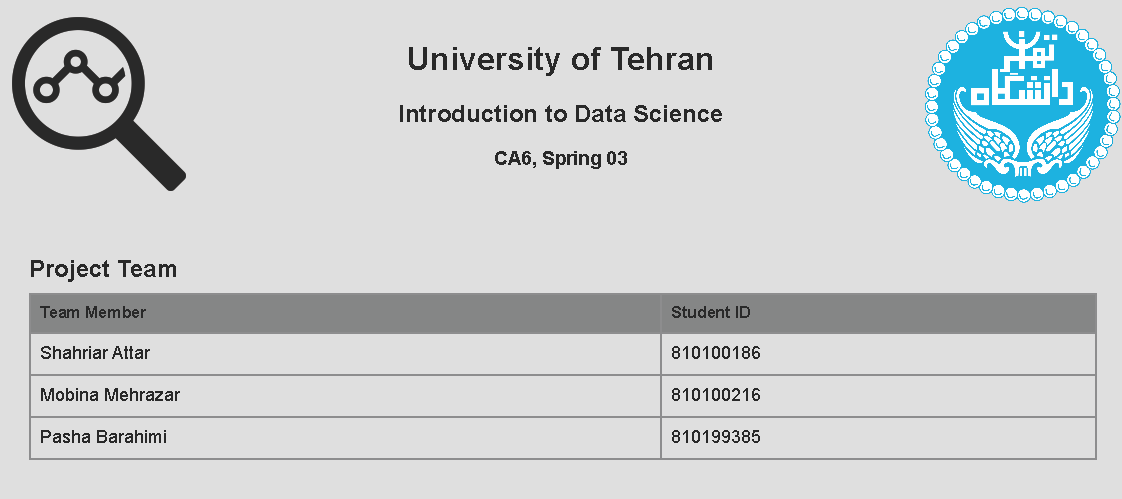

# Dimensionality Reduction and Unsupervised Learning

## Table of Contents

- [Introduction](#introduction)
- [Objectives](#objectives)
- [Tasks](#tasks)
- [Dataset Description](#dataset-description)
- [Environment Setup](#environment-setup)
- [Preprocessing](#preprocessing)
- [Dimensionality Reduction](#dimensionality-reduction)
- [Unsupervised Learning](#unsupervised-learning)
  - [Silhouette Method](#silhouette-method)
  - [K-Means](#k-means)
  - [DBSCAN](#dbscan)
- [Questions](#questions)
- [References](#references)

## Introduction

In this assignment, we will delve into dimensionality reduction and unsupervised learning tasks. Firstly, we should preprocess the provided dataset to prepare it for analysis. Next, we will apply dimensionality reduction techniques to simplify the dataset's complexity. Then, we will use unsupervised learning algorithms to tackle the task. Finally, we evaluate and analyze the results for comparison.

## Objectives

This assignment aims to:

- Implementing dimensionality reduction to simplify the dataset's complexity.
- Using unsupervised learning algorithms to tackle the task.

## Tasks

1. Preprocessing
2. Dimensionality Reduction
3. Unsupervised Learning
4. Evaluation and Analyzing the Results for Comparison

## Dataset Description

In 2014, some researchers published an article called "[Impact of c1HbA Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records.](https://www.hindawi.com/journals/bmri/2014/781670/)" They gathered data on diabetic patients from many hospitals and clinics in America. Some of this data, about 200,000 items with 50 features, has been shared with the public in a way that keeps people's identities private.

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.


## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [1]:
from typing import Optional

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
import pickle


from tabulate import tabulate

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
DIABETIC_DATA = "../data/diabetic_data.csv"
KMEANS_MODEL = "../models/kmeans.pkl"
DBSCAN_MODEL = "../models/dbscan.pkl"
RESULTS = "../result/result.csv"

RANDOM_STATE = 42

In [3]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [4]:
df = pd.read_csv(DIABETIC_DATA)
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


## Preprocessing

Data Preprocessing or Data Preparation is a data mining technique that transforms raw data into an understandable format for ML algorithms. Real-world data is usually noisy (contains errors, outliers, duplicates), incomplete (some values are missed), and could be stored in different places and different formats. The task of Data Preprocessing is to handle these issues.

The dataset contains both numerical and textual values, along with outliers and null values. These inconsistencies can disrupt clustering accuracy. We'll normalize the data extensively and provide detailed explanations for each normalization step in the report file.

Let's drop the duplicates.

In [5]:
duplicates = df.duplicated(subset="patient_nbr").sum()
uniques = df["patient_nbr"].nunique()
print(f"Number of duplicate patients: {duplicates}")
print(f"Number of unique patients: {uniques}")

Number of duplicate patients: 30248
Number of unique patients: 71518


We may have multiple entries for the same patient. First, we'll find the number of patients with unique entries and the number of patients with multiple entries.

In [6]:
patients_unique_entires = df.value_counts("patient_nbr")[df.value_counts("patient_nbr") == 1].shape[0]
patients_dup_entires = df.value_counts("patient_nbr")[df.value_counts("patient_nbr") > 1].shape[0]
print(f"Patients with unique entries: {patients_unique_entires}")
print(f"Patients with duplicate entries: {patients_dup_entires}")

Patients with unique entries: 54745
Patients with duplicate entries: 16773


Then, we'll drop the duplicates and keep only the last entry for each patient.

In [7]:
df = df.drop_duplicates(subset="patient_nbr", keep="last")

Now, we don't need the `patient_nbr` column, so we'll drop it.

In [8]:
df = df.drop(columns=["patient_nbr"], axis=1)

We also have some '?' values in the dataset. We'll replace them with NaN values.

In [9]:
df = df.replace("?", np.nan)

In [10]:
df.value_counts("gender")

gender
Female             38023
Male               33492
Unknown/Invalid        3
Name: count, dtype: int64

In [11]:
df = df[df["gender"] != "Unknown/Invalid"]

In [12]:
df.value_counts("gender")

gender
Female    38023
Male      33492
Name: count, dtype: int64

Also, there are some values in `IDs_mapping.csv` that mean 'Unknown', 'Not Available', 'Not Mapped', 'NULL', and etc. We'll replace them with NaN values.

In [13]:
def replace_values_with_nan(df: pd.DataFrame, replacements: dict[str, list[int]]) -> pd.DataFrame:
    for column, values in replacements.items():
        for value in values:
            df[column] = df[column].replace(value, np.nan)

    df[list(replacements.keys())] = df[list(replacements.keys())].astype("object")
    return df

In [14]:
replacements = {
    "admission_type_id": [5, 6, 8],
    "discharge_disposition_id": [18, 25, 26],
    "admission_source_id": [9, 15, 17, 20, 21],
}

df = replace_values_with_nan(df, replacements)

Let's check the number of missing values in each column.

In [15]:
df.isnull().sum()

encounter_id                    0
race                         1876
gender                          0
age                             0
weight                      68668
admission_type_id            7444
discharge_disposition_id     2964
admission_source_id          5133
time_in_hospital                0
payer_code                  30084
medical_specialty           34523
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         17
diag_2                        290
diag_3                       1146
number_diagnoses                0
max_glu_serum               68038
A1Cresult                   59117
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

Then, we'll find out the null values percentage in each column.

In [16]:
def get_null_percentage(df: pd.DataFrame) -> list[list]:
    percent_null_per_column = df.isnull().sum() / df.shape[0] * 100
    results = [[column, percent_null] for column, percent_null in percent_null_per_column.items() if percent_null > 0]
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def display_null_percentage(df: pd.DataFrame) -> None:
    results = get_null_percentage(df)
    formatted_results = [[col, f"{val:.2f}%"] for col, val in results]
    print(tabulate(formatted_results, headers=["Column", "Percentage of Null Values"], tablefmt="grid"))

In [17]:
display_null_percentage(df)

+--------------------------+-----------------------------+
| Column                   | Percentage of Null Values   |
+==========================+=============================+
| weight                   | 96.02%                      |
+--------------------------+-----------------------------+
| max_glu_serum            | 95.14%                      |
+--------------------------+-----------------------------+
| A1Cresult                | 82.66%                      |
+--------------------------+-----------------------------+
| medical_specialty        | 48.27%                      |
+--------------------------+-----------------------------+
| payer_code               | 42.07%                      |
+--------------------------+-----------------------------+
| admission_type_id        | 10.41%                      |
+--------------------------+-----------------------------+
| admission_source_id      | 7.18%                       |
+--------------------------+----------------------------

Some columns have a high percentage of missing values. We'll drop these columns.

In [18]:
def drop_columns_with_high_null_percentage(df: pd.DataFrame, threshold: float = 80) -> pd.DataFrame:
    results = get_null_percentage(df)
    columns_to_drop = [col for col, val in results if val > threshold]
    print(f"Dropping columns with more than {threshold}% null values: {columns_to_drop}")
    return df.drop(columns=columns_to_drop, axis=1)

In [19]:
df = drop_columns_with_high_null_percentage(df, 40)

Dropping columns with more than 40% null values: ['weight', 'max_glu_serum', 'A1Cresult', 'medical_specialty', 'payer_code']


In [20]:
display_null_percentage(df)

+--------------------------+-----------------------------+
| Column                   | Percentage of Null Values   |
+==========================+=============================+
| admission_type_id        | 10.41%                      |
+--------------------------+-----------------------------+
| admission_source_id      | 7.18%                       |
+--------------------------+-----------------------------+
| discharge_disposition_id | 4.14%                       |
+--------------------------+-----------------------------+
| race                     | 2.62%                       |
+--------------------------+-----------------------------+
| diag_3                   | 1.60%                       |
+--------------------------+-----------------------------+
| diag_2                   | 0.41%                       |
+--------------------------+-----------------------------+
| diag_1                   | 0.02%                       |
+--------------------------+----------------------------

Let's also encode the columns.

In [21]:
all_columns = df.select_dtypes(include=["object"]).columns.tolist()
ordinal_columns = ["age"]
label_columns = [col for col in all_columns if col not in ordinal_columns]

print(label_columns)

['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [22]:
df.value_counts("age")

age
[70-80)     18160
[60-70)     15907
[50-60)     12349
[80-90)     11864
[40-50)      6756
[30-40)      2650
[90-100)     2040
[20-30)      1111
[10-20)       525
[0-10)        153
Name: count, dtype: int64

In [23]:
age_values = df.value_counts("age").index.tolist()
age_values.sort()
age_values

['[0-10)',
 '[10-20)',
 '[20-30)',
 '[30-40)',
 '[40-50)',
 '[50-60)',
 '[60-70)',
 '[70-80)',
 '[80-90)',
 '[90-100)']

In [24]:
ordinal_values = {
    "age": age_values
}

In [25]:
label_encoders = {}

for col in ordinal_columns:
    ordinal_encoder = OrdinalEncoder(categories=[ordinal_values[col]])
    df[col] = ordinal_encoder.fit_transform(df[[col]])

for col in label_columns:
    if col not in label_encoders:
        label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

Then, we'll impute the missing values.

In [26]:
knn_imputer = KNNImputer()
df_imputed = knn_imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71515 entries, 0 to 71514
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              71515 non-null  float64
 1   race                      71515 non-null  float64
 2   gender                    71515 non-null  float64
 3   age                       71515 non-null  float64
 4   admission_type_id         71515 non-null  float64
 5   discharge_disposition_id  71515 non-null  float64
 6   admission_source_id       71515 non-null  float64
 7   time_in_hospital          71515 non-null  float64
 8   num_lab_procedures        71515 non-null  float64
 9   num_procedures            71515 non-null  float64
 10  num_medications           71515 non-null  float64
 11  number_outpatient         71515 non-null  float64
 12  number_emergency          71515 non-null  float64
 13  number_inpatient          71515 non-null  float64
 14  diag_1

In [27]:
df_imputed.isnull().sum().sum()

0

In [28]:
df = df_imputed
df = df.drop_duplicates()

We should also remove the outliers.

In [29]:
def plot_horizontal_box_plot(df, columns):
    plt.figure(figsize=(10, 6))
    df[columns].boxplot(vert=0)
    plt.title("Horizontal Boxplot of Specified Columns")
    plt.xlabel("Values")
    plt.ylabel("Columns")
    plt.show()

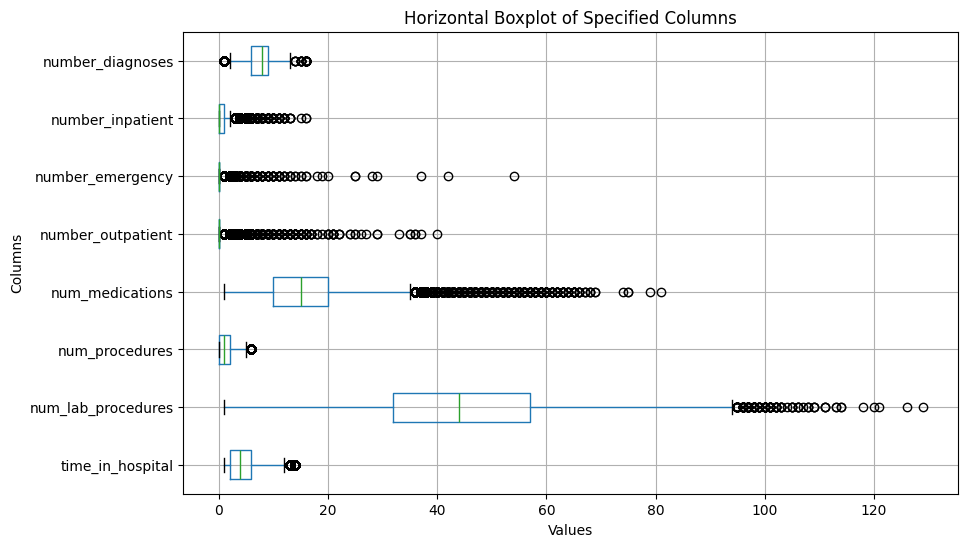

In [30]:
plot_horizontal_box_plot(df, ["time_in_hospital",
                              "num_lab_procedures",
                              "num_procedures",
                              "num_medications",
                              "number_outpatient",
                              "number_emergency",
                              "number_inpatient",
                              "number_diagnoses"])

In [31]:
def delete_outliers(df: pd.DataFrame, columns: list[str], threshold: float = 0.05) -> pd.DataFrame:
    isolation_forest = IsolationForest(contamination=threshold)
    outliers = isolation_forest.fit_predict(df[columns])
    return df.loc[outliers == 1]

In [32]:
df = delete_outliers(df, df.select_dtypes(include=["int64", "float64"]).columns.tolist(), 0.1)

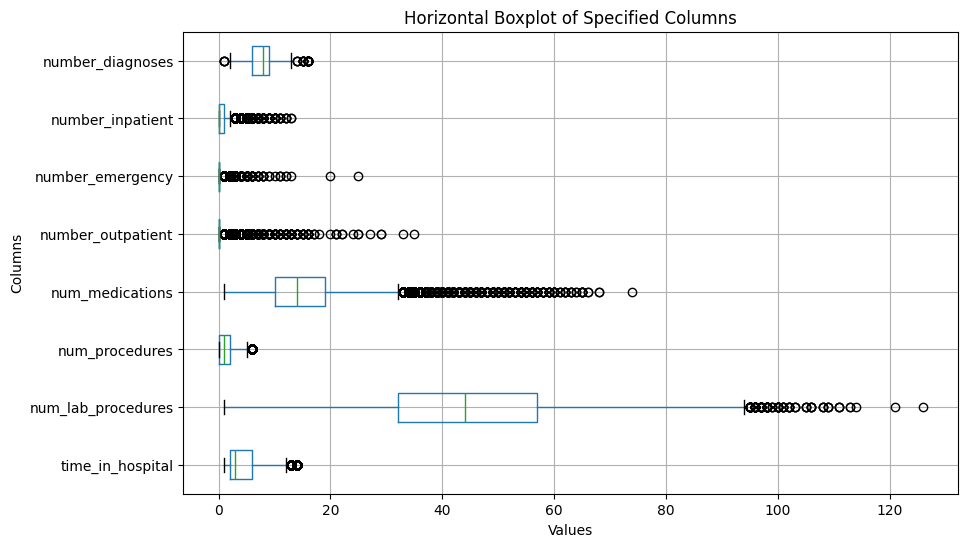

In [33]:
plot_horizontal_box_plot(df, ["time_in_hospital",
                              "num_lab_procedures",
                              "num_procedures",
                              "num_medications",
                              "number_outpatient",
                              "number_emergency",
                              "number_inpatient",
                              "number_diagnoses"])

In [34]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64363 entries, 0 to 64362
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              64363 non-null  float64
 1   race                      64363 non-null  float64
 2   gender                    64363 non-null  float64
 3   age                       64363 non-null  float64
 4   admission_type_id         64363 non-null  float64
 5   discharge_disposition_id  64363 non-null  float64
 6   admission_source_id       64363 non-null  float64
 7   time_in_hospital          64363 non-null  float64
 8   num_lab_procedures        64363 non-null  float64
 9   num_procedures            64363 non-null  float64
 10  num_medications           64363 non-null  float64
 11  number_outpatient         64363 non-null  float64
 12  number_emergency          64363 non-null  float64
 13  number_inpatient          64363 non-null  float64
 14  diag_1

In [35]:
df.columns.size

44

In [36]:
df_encounter_id = df["encounter_id"]
df = df.drop(columns=["encounter_id"], axis=1)

In [37]:
df_encounter_id = df_encounter_id.astype(int)
df_encounter_id.info()

<class 'pandas.core.series.Series'>
RangeIndex: 64363 entries, 0 to 64362
Series name: encounter_id
Non-Null Count  Dtype
--------------  -----
64363 non-null  int32
dtypes: int32(1)
memory usage: 251.5 KB


We should also normalize the data.

In [38]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)

## Dimensionality Reduction

Some data mining algorithms, like K-Means, struggle with accurately clustering data when confronted with numerous features, leading to high dimensionality. This issue isn't exclusive to datasets with hundreds or thousands of features; even just ten features can pose accuracy challenges. Feature or dimensionality reduction aims to address this by transforming the original feature set into a smaller set of derived features that retain most of the original information.

Principal Component Analysis (PCA) is a widely used technique for feature reduction. It condenses the original dataset into a set number of features known as principal components. The desired number of principal components must be specified. In this section, we'll utilize PCA to reduce the dimensionality of the dataset. This approach is recommended if there are numerous variables, manual variable selection is impractical, or segmentation results are unsatisfactory.

For finding a reasonable number of components to keep in PCA, we must be aware that the explained variance ratio has a negative relationship with the silhouette score. We should find a balance between the two. Let's plot the explained variance ratio and the silhouette score for different numbers of components.

In [39]:
params = {
    "n_components": [1, 3, 4, 12],
    "n_clusters": [3, 4],
    "init": ["k-means++"],
}

In [40]:
grid = ParameterGrid(params)

results = []

for param in tqdm.tqdm(grid):
    pca = PCA(n_components=param["n_components"], random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)

    kmeans = KMeans(n_clusters=param["n_clusters"], init=param["init"], random_state=RANDOM_STATE)
    kmeans.fit(X_pca)

    score = silhouette_score(X_pca, kmeans.labels_)
    results.append([param["n_components"], param["n_clusters"], score, pca.explained_variance_ratio_.sum()])

100%|██████████| 8/8 [07:29<00:00, 56.23s/it]


In [41]:
results_df = pd.DataFrame(results, columns=["n_components", "n_clusters", "silhouette score", "explained variance ratio"])
max_scores = results_df.groupby("n_components")["silhouette score"].max()
max_scores = results_df[results_df["silhouette score"].isin(max_scores)]
max_scores = max_scores.sort_values("n_components")
max_scores

,n_components,n_clusters,silhouette score,explained variance ratio
0,1,3,0.921,0.230
5,3,4,0.657,0.476
6,4,4,0.493,0.541
7,12,4,0.239,0.858


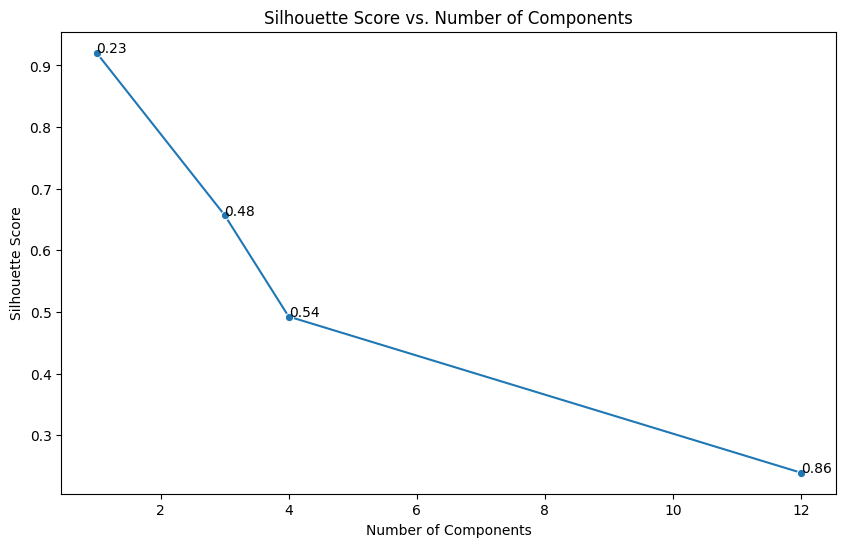

In [42]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=max_scores, x="n_components", y="silhouette score", marker="o")
for _, row in max_scores.iterrows():
    plt.text(row["n_components"], row["silhouette score"], f"{row['explained variance ratio']:.2f}")
plt.title("Silhouette Score vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Silhouette Score")
plt.show()

Also, as we know, the number of components has a positive relationship with the explained variance ratio.

In [43]:
def scree_plot(explained_variance_ratio: np.ndarray) -> None:
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='orange', label='Cumulative Explained Variance Ratio')
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance Ratio')
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
    plt.grid(True)
    plt.legend()

    for i in range(len(explained_variance_ratio)):
        plt.vlines(x=i + 1, ymin=0, ymax=cumulative_variance_ratio[i], colors='red', alpha=0.5)

    plt.show()

In [44]:
pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

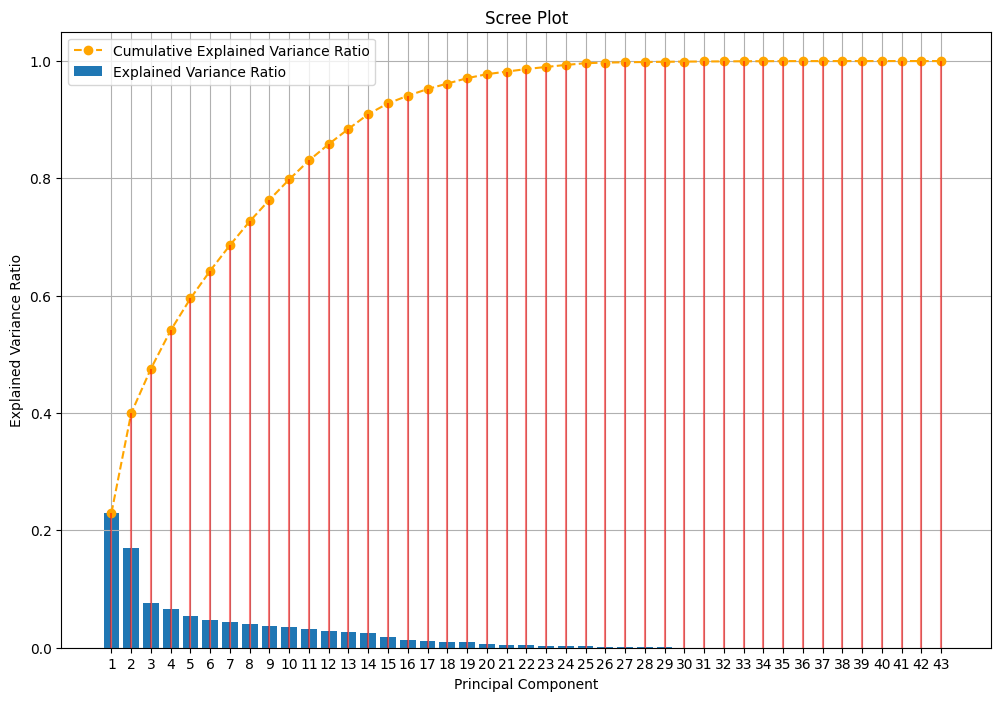

In [45]:
scree_plot(pca.explained_variance_ratio_)

So, we should choose a reasonable number of components to strike a balance between the explained variance ratio and the silhouette score. We'll choose the number of components that keeps the explained variance ratio above 0.7.

In [46]:
pca = PCA(n_components=0.7, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

In [75]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Singular values:", pca.singular_values_)
print("Number of components:", pca.n_components_)
print("Number of samples:", pca.n_samples_)

Explained variance ratio: [0.22994794 0.16976867 0.07606794 0.0652396  0.0543567  0.04732001
 0.04345769 0.04065057]
Singular values: [147.42443189 126.67282956  84.79212632  78.52543288  71.67723649
  66.87705106  64.08966627  61.98520402]
Number of components: 8
Number of samples: 64363


In [48]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: 0.7268091287130234


## Unsupervised Learning

### Silhouette Method

The Silhouette Method is a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its cluster compared to other clusters, by providing a succinct graphical representation of how well each object has been classified.

### K-Means

K-Means Clustering is a type of Unsupervised Machine Learning algorithm that organizes an unlabeled dataset into distinct clusters. This method assigns data points to one of the K clusters based on their proximity to the cluster centers. Initially, cluster centroids are randomly placed in space. Then, each data point is assigned to the nearest cluster centroid. Subsequently, new cluster centroids are calculated. This iterative process continues until it converges on well-defined clusters.

We can also use the Elbow Method to find the optimal number of clusters. The Elbow Method is a heuristic used to determine the optimal number of clusters in a dataset. The method involves running the K-Means clustering algorithm multiple times, with different numbers of clusters, and calculating the Within-Cluster Sum of Squares (WCSS) for each run. The WCSS is the sum of the squared distances between each data point and the centroid in a cluster. The optimal number of clusters is the point at which the rate of decrease in WCSS slows down significantly, forming an "elbow" in the plot of WCSS against the number of clusters. However, we are asked to plot the silhouette score for different numbers of clusters. So, we'll not use the Elbow Method.

In [49]:
kmean_params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "init": ["k-means++"],
    "random_state": [RANDOM_STATE],
}

kmean_grid = ParameterGrid(kmean_params)

In [50]:
kmeans_silhouette_scores = []

for params in tqdm.tqdm(kmean_grid):
    kmeans = KMeans(**params)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_pca, labels)
    kmeans_silhouette_scores.append(score)

kmeans_best_params = list(kmean_grid)[np.argmax(kmeans_silhouette_scores)]

100%|██████████| 9/9 [07:05<00:00, 47.32s/it]


In [51]:
print("KMeans Results:")
print(f"Best Parameters: {kmeans_best_params}")
print(f"Best Silhouette Score: {np.max(kmeans_silhouette_scores)}")

KMeans Results:
Best Parameters: {'init': 'k-means++', 'n_clusters': 7, 'random_state': 42}
Best Silhouette Score: 0.3552358195449451


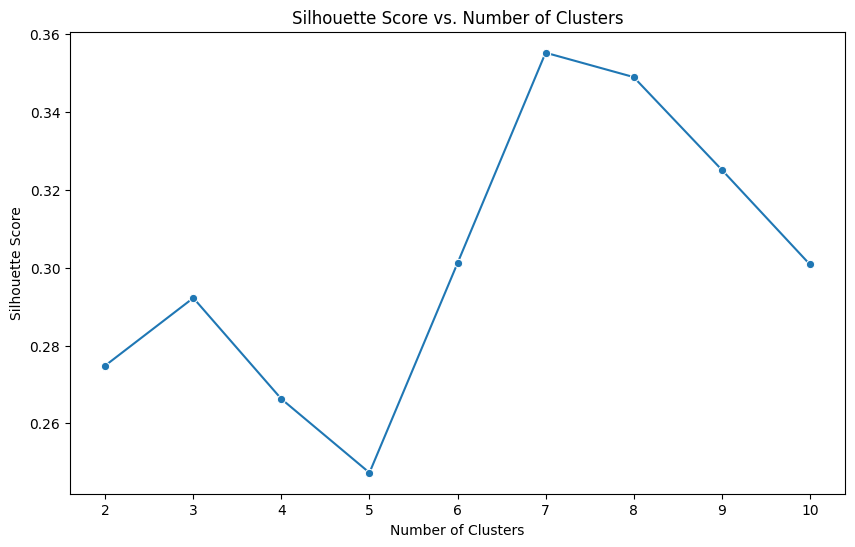

In [52]:
results_df = pd.DataFrame(kmeans_silhouette_scores, columns=["silhouette score"])
results_df["n_clusters"] = [params["n_clusters"] for params in kmean_grid]

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="n_clusters", y="silhouette score", marker="o")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [53]:
best_kmeans = KMeans(**kmeans_best_params)
best_kmeans.fit(X_pca)

KMeans(n_clusters=7, random_state=42)

In [54]:
with open(KMEANS_MODEL, "wb") as f:
    pickle.dump(best_kmeans, f)

### DBSCAN

DBSCAN is an unsupervised clustering algorithm, offering an alternative to KMeans and hierarchical clustering. It relies on two key parameters: Epsilon (ɛ), defining the neighborhood radius, and Minimum Points (minPts), specifying the minimum number of points to form a cluster. Epsilon determines the similarity threshold between points, influencing cluster size, while minPts affects cluster robustness and noise handling. Balancing these parameters is crucial for effective clustering without splitting valid clusters or aggregating unrelated points.

In [55]:
db_params = {
    "eps": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples": [5, 10, 15, 20, 25],
}

db_grid = ParameterGrid(db_params)

In [56]:
dbscan_silhouette_scores = []

for params in tqdm.tqdm(db_grid):
    db = DBSCAN(**params)
    db.fit(X_pca)
    labels = db.labels_

    try:
        score = silhouette_score(X_pca, labels)
    except ValueError:
        # Handle the case where there is only one cluster or no clusters
        score = float('-inf')

    dbscan_silhouette_scores.append(score)

dbscan_best_params = list(db_grid)[np.argmax(dbscan_silhouette_scores)]

100%|██████████| 25/25 [27:57<00:00, 67.09s/it]


In [57]:
print("DBSCAN Results:")
print(f"Best Parameters: {dbscan_best_params}")
print(f"Best Silhouette Score: {np.max(dbscan_silhouette_scores)}")

DBSCAN Results:
Best Parameters: {'eps': 0.5, 'min_samples': 25}
Best Silhouette Score: 0.38867444217579555


In [58]:
results_df = pd.DataFrame(dbscan_silhouette_scores, columns=["silhouette score"])
results_df["eps"] = [params["eps"] for params in db_grid]
results_df["min_samples"] = [params["min_samples"] for params in db_grid]

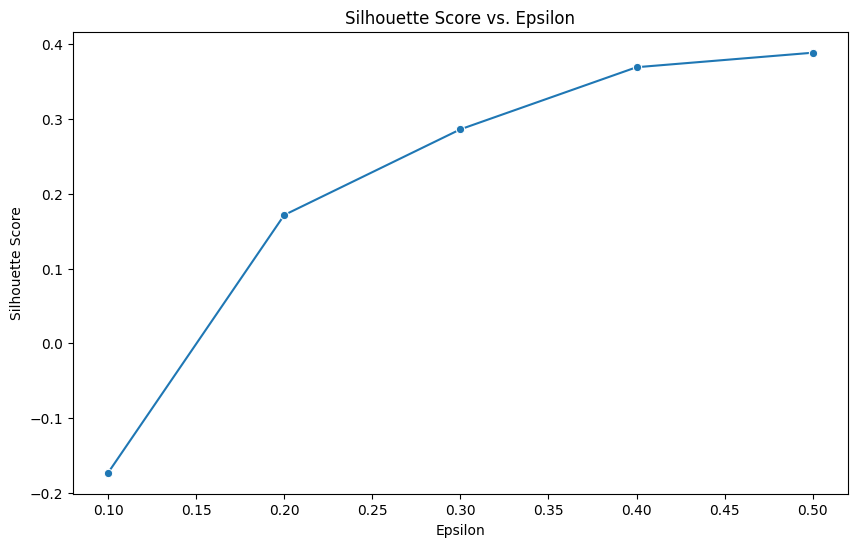

In [59]:
max_scores = results_df.groupby("eps")["silhouette score"].max()
max_scores = results_df[results_df["silhouette score"].isin(max_scores)]
max_scores = max_scores.sort_values("eps")

plt.figure(figsize=(10, 6))
sns.lineplot(data=max_scores, x="eps", y="silhouette score", marker="o")
plt.title("Silhouette Score vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Silhouette Score")
plt.show()

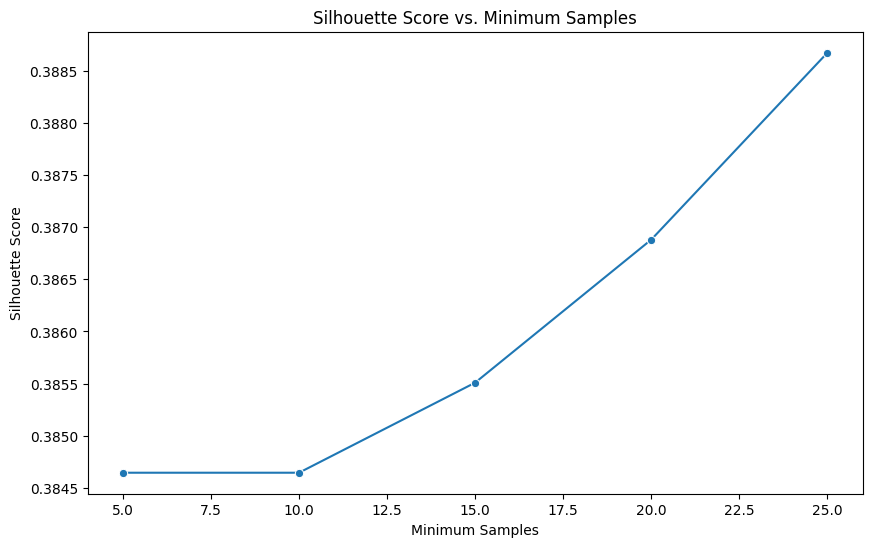

In [60]:
max_scores = results_df.groupby("min_samples")["silhouette score"].max()
max_scores = results_df[results_df["silhouette score"].isin(max_scores)]
max_scores = max_scores.sort_values("min_samples")

plt.figure(figsize=(10, 6))
sns.lineplot(data=max_scores, x="min_samples", y="silhouette score", marker="o")
plt.title("Silhouette Score vs. Minimum Samples")
plt.xlabel("Minimum Samples")
plt.ylabel("Silhouette Score")
plt.show()

In [61]:
best_dbscan = DBSCAN(**dbscan_best_params)
best_dbscan.fit(X_pca)

DBSCAN(min_samples=25)

In [62]:
with open(DBSCAN_MODEL, "wb") as f:
    pickle.dump(best_dbscan, f)

Utilizing the silhouette method, we'll determine the optimal number of clusters for the K-means method and the optimal input parameters (minPnt, eps) for the DBSCAN method. Based on the obtained values, we will then store the best result from each method in a CSV file containing only the columns: id_encounter, kmean_label, and dbscan_label.

In [63]:
with open(KMEANS_MODEL, "rb") as f:
    kmeans = pickle.load(f)

with open(DBSCAN_MODEL, "rb") as f:
    dbscan = pickle.load(f)

In [64]:
df_results = pd.DataFrame(df_encounter_id, columns=["encounter_id"])
df_results["kmean_label"] = kmeans.labels_
df_results["dbscan_label"] = dbscan.labels_
df_results.rename(columns={"encounter_id": "id_encounter"}, inplace=True)

df_results.to_csv(RESULTS, index=False)

In [65]:
def biplot_with_clusters(X_pca: np.ndarray, labels: np.ndarray, pca_components: np.ndarray, clustering_method: str, n_clusters: Optional[int] = None, cluster_centers: Optional[np.ndarray] = None) -> None:
    plt.figure(figsize=(10, 6))

    if clustering_method == "KMeans":
        for cluster_label in range(n_clusters):
            plt.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], label=f"Cluster {cluster_label}")
            cluster_center = cluster_centers[cluster_label]
            plt.scatter(cluster_center[0], cluster_center[1], s=200, c="black", marker="X")

    elif clustering_method == "DBSCAN":
        unique_labels = np.unique(labels)
        for cluster_label in unique_labels:
            if cluster_label == -1:
                noise_mask = labels == cluster_label
                plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c="black", alpha=0.5, label="Noise")
            else:
                cluster_mask = labels == cluster_label
                plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], label=f"Cluster {cluster_label}")

    for i, (component1, component2) in enumerate(zip(pca_components[0], pca_components[1])):
        plt.arrow(0, 0, component1, component2, color="r", alpha=0.5)
        plt.quiver(0, 0, component1, component2, angles="xy", scale_units="xy", scale=1, alpha=0.5)

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"Biplot with {clustering_method} Cluster Labels")
    plt.legend()
    plt.grid(True)
    plt.show()


In [66]:
def plot_3d_scatter_with_clusters(X_pca: np.ndarray, labels: np.ndarray, clustering_method: str, n_clusters: Optional[int] = None) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")

    if clustering_method == "KMeans":
        for cluster_label in range(n_clusters):
            ax.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], X_pca[labels == cluster_label, 2], label=f"Cluster {cluster_label}")

    elif clustering_method == "DBSCAN":
        unique_labels = np.unique(labels)
        for cluster_label in unique_labels:
            if cluster_label == -1:
                noise_mask = labels == cluster_label
                ax.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], X_pca[noise_mask, 2], c="black", alpha=0.5, label="Noise")
            else:
                cluster_mask = labels == cluster_label
                ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], X_pca[cluster_mask, 2], label=f"Cluster {cluster_label}")

    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title(f"3D Scatter Plot with {clustering_method} Cluster Labels")

    ax.legend()
    plt.show()

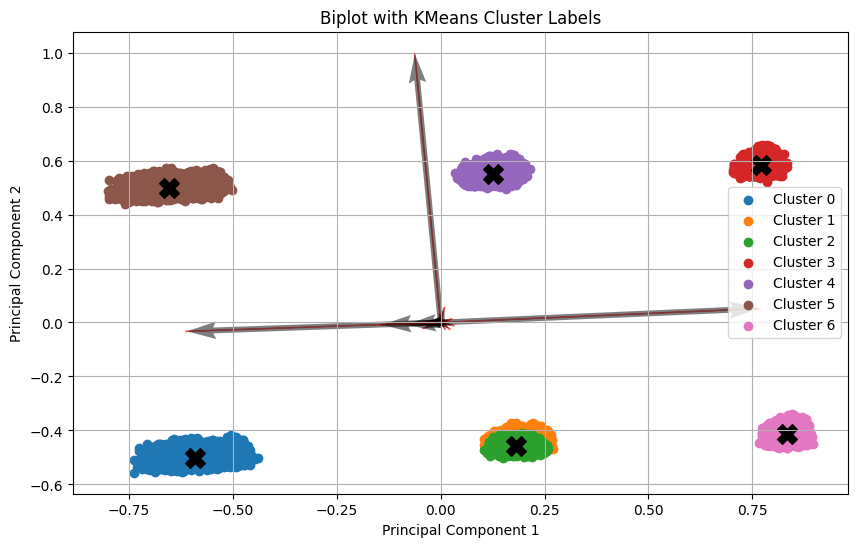

In [67]:
biplot_with_clusters(X_pca, kmeans.labels_, pca.components_, "KMeans", n_clusters=kmeans.n_clusters, cluster_centers=kmeans.cluster_centers_)

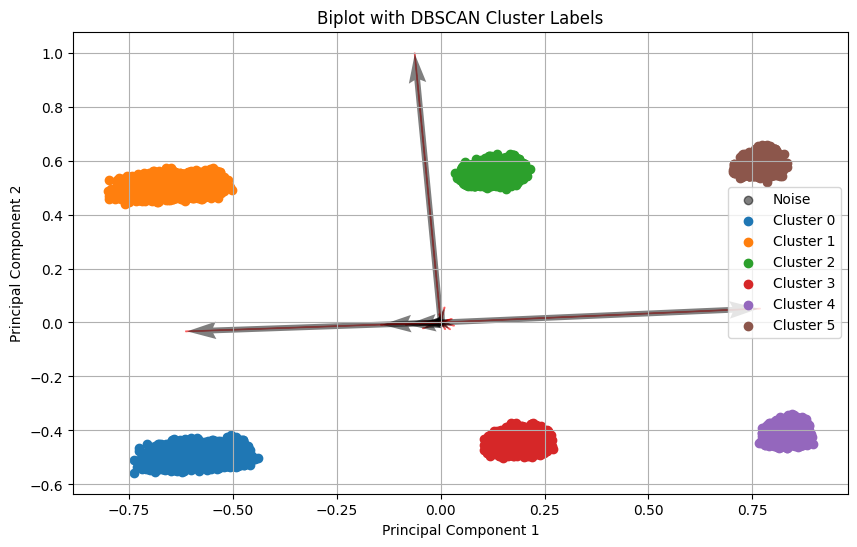

In [68]:
biplot_with_clusters(X_pca, dbscan.labels_, pca.components_, "DBSCAN")

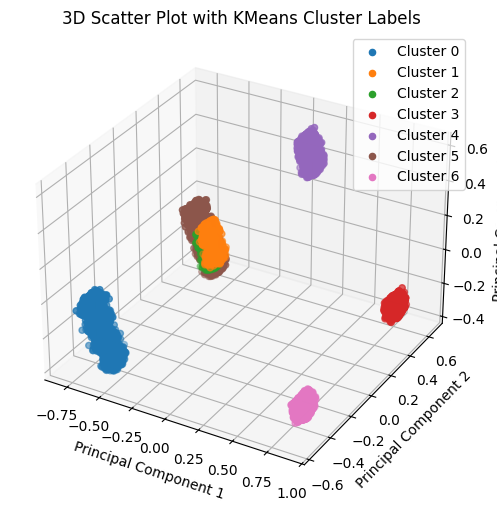

In [69]:
plot_3d_scatter_with_clusters(X_pca, kmeans.labels_, "KMeans", n_clusters=kmeans.n_clusters)

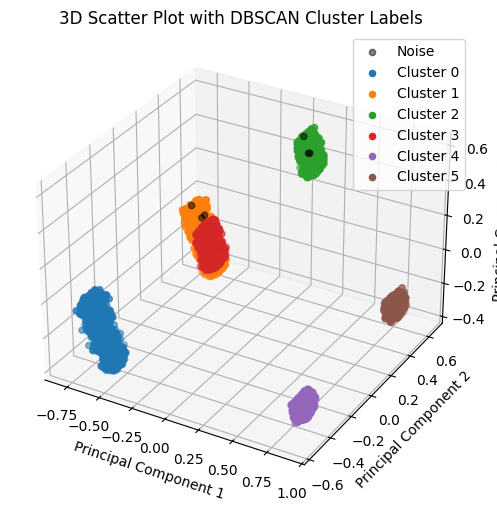

In [70]:
plot_3d_scatter_with_clusters(X_pca, dbscan.labels_, "DBSCAN")

## Questions

1. **What preprocessing steps did you perform on the dataset? Provide clear reasons for each decision made.**

    At the beginning of the preprocessing section, we dropped the duplicates. We may have multiple entries for the same patient. First, we found the number of patients with unique entries and the number of patients with multiple entries. Then, we dropped the duplicates and kept only the last entry for each patient. We also dropped the `patient_nbr` column because we don't need it. We replaced the '?' values in the dataset with NaN values. We also replaced some values in `IDs_mapping.csv` that mean 'Unknown', 'Not Available', 'Not Mapped', 'NULL', and etc. with NaN values. We checked the number of missing values in each column and found out the null values percentage in each column. Some columns had a high percentage of missing values, so we dropped these columns (more than 40%). We encoded the columns (some of them with `OrdinalEncoder` and some of them with `LabelEncoder`). We didn't use one-hot encoding since we already had so many features and one-hot encoding would make it worse! Then, we imputed the missing values using `KNN Imputer`. Finally, We removed the outliers using `IsolationForest` and normalized the data.

2. **What portion of the dataset did you retain during dimensionality reduction, and which variables were retained? Could you elaborate on the rationale behind this decision?**

    We chose the number of components that keeps the explained variance ratio above 0.7. This resulted in retaining 8 components. We can check the retained variables by looking at the `pca.components_` attribute. The rationale behind this decision is that we should find a balance between the explained variance ratio and the silhouette score. The explained variance ratio has a negative relationship with the silhouette score. So, we should choose a reasonable number of components to strike a balance between the explained variance ratio and the silhouette score.

3. **Include a plot illustrating the silhouette coefficient plotted against the input parameters for each clustering method within the report file.**

    The plot illustrating the silhouette coefficient plotted against the input parameters for each clustering method is included in the report file.

4. **How can we determine the optimal number of clusters in K-Means?**

    The optimal number of clusters in K-Means can be determined using the Silhouette Method. The Silhouette Method is a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its cluster compared to other clusters, by providing a succinct graphical representation of how well each object has been classified. We could use a `ParameterGrid` to find the optimal number of clusters in K-Means. In the `ParameterGrid`, we can specify the range of the number of clusters to try. Then, we can calculate the silhouette score for each number of clusters and choose the number of clusters that maximizes the silhouette score.

    Also, we can use the Elbow Method to find the optimal number of clusters. The Elbow Method is a heuristic used to determine the optimal number of clusters in a dataset. The method involves running the K-Means clustering algorithm multiple times, with different numbers of clusters, and calculating the Within-Cluster Sum of Squares (WCSS) for each run. The WCSS is the sum of the squared distances between each data point and the centroid in a cluster. The optimal number of clusters is the point at which the rate of decrease in WCSS slows down significantly, forming an "elbow" in the plot of WCSS against the number of clusters. The `inertia_` attribute of the KMeans object can be used to calculate the WCSS.

5. **How can we determine the optimal epsilon value and minPts in DBSCAN?**

    The optimal epsilon value and minPts in DBSCAN can be determined using the Silhouette Method. The Silhouette Method is a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its cluster compared to other clusters, by providing a succinct graphical representation of how well each object has been classified. We could use a `ParameterGrid` to find the optimal epsilon value and minPts in DBSCAN. In the `ParameterGrid`, we can specify the range of epsilon values and minPts to try. Then, we can calculate the silhouette score for each epsilon value and minPts and choose the epsilon value and minPts that maximize the silhouette score.

6. **When would you recommend using K-Means, and when would you suggest using DBSCAN instead?**

    K-Means and DBSCAN are both popular clustering algorithms, but they have different strengths and weaknesses, making them suitable for different scenarios. Here are some guidelines on when to use each:

    *When to Use K-Means*

    1. **Well-Separated Clusters**: We can use K-Means when we have data that is well-separated into distinct clusters.
    2. **Spherical Clusters**: K-Means works well when clusters are roughly spherical (i.e., clusters are shaped like balls in multi-dimensional space).
    3. **Scalability**: K-Means is computationally efficient and scales well to large datasets, making it suitable for big data applications.
    4. **Easy to Implement**: If we need a straightforward and easy-to-implement algorithm, K-Means is a good choice.
    5. **Fixed Number of Clusters**: K-Means requires us to specify the number of clusters (K) beforehand. We should use it when we have a good estimate or prior knowledge of the number of clusters in our data.
    6. **Sensitivity to Initialization**: K-Means is suitable when we can handle its sensitivity to initial centroids, possibly by using techniques like K-Means++ for better initialization.

    *When to Use DBSCAN*

    7. **Arbitrary Shape Clusters**: DBSCAN is preferable when our clusters have arbitrary shapes, not necessarily spherical.
    8. **Noise and Outliers**: We can use DBSCAN if our data contains noise and outliers, as it can effectively identify and handle them by marking them as noise.
    9. **Density-Based Clustering**: DBSCAN is ideal when we expect clusters to be defined by high-density regions. It can find clusters of varying densities, which is a limitation of K-Means.
    10. **No Need for Pre-Specifying Number of Clusters**: DBSCAN does not require specifying the number of clusters beforehand. It determines the number of clusters based on the data and the density parameters.
    11. **Small to Medium Datasets**: While DBSCAN can be computationally more expensive and may not scale as well as K-Means for very large datasets, it is suitable for small to medium-sized datasets.
    12. **Parameter Sensitivity**: DBSCAN requires careful tuning of parameters like the radius for the neighborhood (`eps`) and the minimum number of points (`minPts`). It is useful when we can invest the effort to fine-tune these parameters for better clustering results.

    *Summary*

    - **K-Means** is suitable for large datasets with well-separated, spherical clusters and when we can pre-specify the number of clusters.
    - **DBSCAN** is better for data with arbitrary-shaped clusters, containing noise and outliers, and where the number of clusters is not known beforehand or varies based on density.

    Choosing between K-Means and DBSCAN depends on the nature of your data and the specific requirements of our clustering task.

## References

- [Dataset](https://www.hindawi.com/journals/bmri/2014/781670/)
- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Silhouette Method](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Silhouette Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [K-Means](https://en.wikipedia.org/wiki/K-means_clustering)
- [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)
- [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
